In [43]:
import pandas as pd
import numpy as np
from zipline import run_algorithm
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import AverageDollarVolume, CustomFactor, Returns
from zipline.api import (
    attach_pipeline,
    calendars,
    pipeline_output,
    date_rules,
    time_rules,
    set_commission, 
    set_slippage,
    record,
    order_target_percent,
    get_open_orders,
    get_datetime,
    schedule_function
)
import pandas_datareader as web


In [5]:
# the number of long and short stocks
N_LONGS = N_SHORTS = 50

In [9]:
# custom momentum factor
class MomentumFactor(CustomFactor):
    inputs = [USEquityPricing.close, Returns(window_length=126)]
    window_length = 252
    
    def compute(self, today, assets, out, prices, returns):
        out[:] = (
            (prices[-21] - prices[-252]) / prices[-252]
            - (prices[-1] - prices[-21]) / prices[-21]
        ) / np.nanstd(returns, axis=0)

In [11]:
# function for the pipeline
def make_pipeline():
    momentum = MomentumFactor()
    dollar_volume = AverageDollarVolume(
        window_length=30)
    return Pipeline(
        columns={
            "factor": momentum,
            "longs": momentum.top(N_LONGS),
            "shorts" : momentum.bottom(N_SHORTS),
            "ranking" : momentum.rank(),
        },
        screen=dollar_volume.top(100),
    )

In [13]:
# hook our factor pipeline before trading starts
def before_trading_start(context, data):
    context.factor_data = pipeline_output(
        "factor_pipeline"
    )

In [15]:
# initialize the function above to activate when the backtest starts
def initialize(context):
    attach_pipeline(make_pipeline(), "factor_pipeline")
    schedule_function(
        rebalance,
        date_rules.week_start(),
        time_rules.market_open(),
        calendar=calendars.US_EQUITIES,
    )

In [17]:
# a function that contains the logic to rebalance our portfolio. 
def rebalance(context, data):
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)
    assets = factor_data.index
    record(prices=data.current(assets, "price"))
    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = set(
        context.portfolio.positions.keys()) - set(
            longs.union(shorts))
    exec_trades(
        data,
        assets=divest,
        target_percent=0
    )
    exec_trades(
        data,
        assets=longs,
        target_percent=1 / N_LONGS
    )
    exec_trades(
        data,
        assets=shorts,
        target_percent=-1 / N_SHORTS
    )


In [19]:
# function which lopps through the provided assets and executes the orders
def exec_trades(data, assets, target_percent):
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)


In [49]:
# run the backtest using the 'run_algorithm' function
start = pd.Timestamp("2016-01-01")
end = pd.Timestamp("2018-12-31")
perf = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    before_trading_start=before_trading_start,
    capital_base=100000,
    bundle="quandl", # changed from 'quandl'
)

C:\Users\tsebo\AppData\Roaming\Python\Python310\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\Anaconda\An\envs\my-quant-stack\lib\site-packages\zipline\utils\events.py:486: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  .view(np.int64)
C:\Users\tsebo\AppData\Roaming\Python\Python310\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\tsebo\AppData\Roaming\Python\Python310\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\tsebo\AppData\Roaming\Python\Python310\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice

In [51]:
perf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2016-01-04 21:00:00+00:00 to 2018-12-31 21:00:00+00:00
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              754 non-null    datetime64[ns, UTC]
 1   period_close             754 non-null    datetime64[ns, UTC]
 2   long_value               754 non-null    float64            
 3   short_value              754 non-null    float64            
 4   long_exposure            754 non-null    float64            
 5   pnl                      754 non-null    float64            
 6   short_exposure           754 non-null    float64            
 7   capital_used             754 non-null    float64            
 8   orders                   754 non-null    object             
 9   transactions             754 non-null    object             
 10  gross_leverage           754 non-null    float64 

<Axes: title={'center': 'Cumulative returns'}>

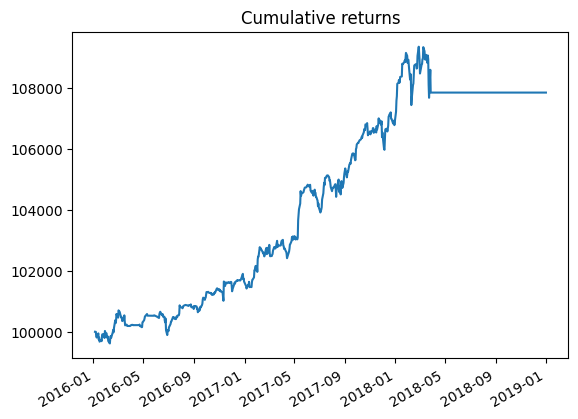

In [53]:
# Graph of the algorithm's performance
perf.portfolio_value.plot(title="Cumulative returns")

<Axes: >

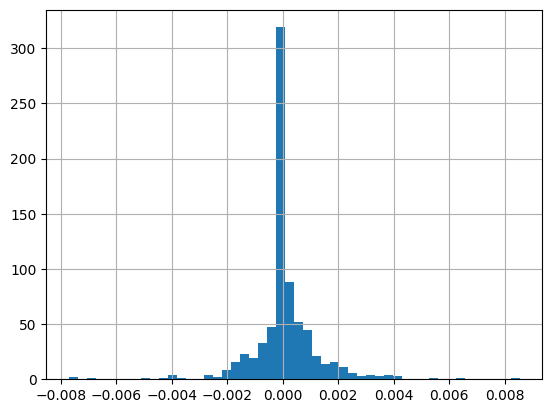

In [55]:
# Histogram of the daily returns
perf.returns.hist(bins=50)

<Axes: >

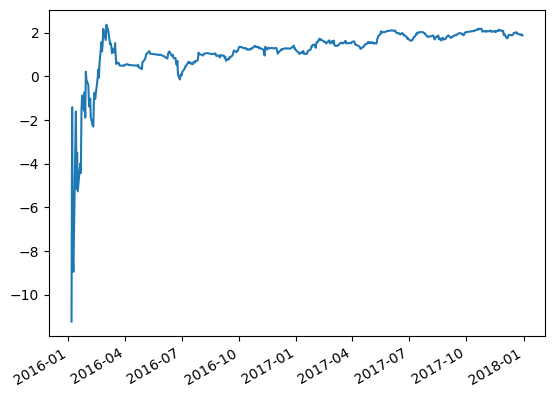

In [29]:
perf.sharpe.plot()